# __Customer Churn Analysis__

__Context__: Telco, a popular telecom company just started to experience customer churn, The Sales manager is deeply concerned as he is unsure of the cause as sales data include many variables. The goal is to identify the key drivers of this decline and recommend ways to averse it.

__Broad Problem__: What is the cause of the customer churn at Telco?

__Narrow Problem__: What factors are driving customer churn?

<u>Why this matters?</u>
1. Customer churn is critical as it leads to lost revenue and increase costs to get back those customers
2. Telco being a reputable company, customer churn could really affect it's image 
3. We need to look at the factors holistically make better decisions instead of looking for a short fix

<u>Next Steps</u>
1. Analyse dataset and identify variables that could affect churn rate 
2. Check relationships between churn rate and the other variables
3. Confirm with hypotheses tests or confidence intervals
4. Use Statistical models to determine which factors could impact sales


__Data Source__: Kaggle Telco Customer Churn Dataset – Contains customer data like tenure, monthly charges, and churn status.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from statsmodels.sandbox.predict_functional import predict_functional
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown
import pickle

In [2]:
# Load data into notebook
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## __Inspect Data__

At the beginning of our analyses, we need to view the dataset in order to have a feel of the dataset we are working with, and make necessary adjustment to make our analyses easier

In [3]:
# Inspect dataset
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# View columns to identify variables that could affect customer churn
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### __Variable Selection__

They are various columns in the dataset, but we shall base analyses on variables or attributes that we believe should have a direct link to customer churn and they are:
1. __Tenure__: Represents the length of time (in months) a customer has been with the company. Longer tenure might suggest greater loyalty or satisfaction, potentially reducing the likelihood of churn.
2. __InternetService__: Indicates the type of internet service a customer subscribes to (e.g., DSL, Fiber optic, or None). Differences in service quality, speed, or pricing could affect customer satisfaction and thus impact churn rates.
3. __Contract__: Refers to the customer’s contract type (e.g., month-to-month, one-year, two-year). Customers on shorter contracts, like month-to-month, may churn more easily since they aren’t committed long-term.
4. __MonthlyCharges__: The amount a customer pays each month. Higher charges could lead to dissatisfaction and higher churn if customers perceive low value for their money.
5. __TotalCharges__: The total amount a customer has paid over their tenure. This might reflect the combined effect of tenure and monthly charges, though its direct influence on churn needs exploration.
6. __Churn__ : The outcome variable (e.g. Yes/No), showing whether a customer has left the service. This is what we’re trying to understand and predict.

In [5]:
# Focusing on hypothesized variables
columns = ['tenure','InternetService','Contract','MonthlyCharges', 'TotalCharges', 'Churn']
data = data[columns]

data.head()

,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn
0,1,DSL,Month-to-month,29.85,29.85,No
1,34,DSL,One year,56.95,1889.5,No
2,2,DSL,Month-to-month,53.85,108.15,Yes
3,45,DSL,One year,42.30,1840.75,No
4,2,Fiber optic,Month-to-month,70.70,151.65,Yes


In [6]:
# Replace Churn variables with 1 and 0, they make analyses easier
data['Churn'] = data['Churn'].replace({'Yes':1,'No':0})

data.head()

/var/folders/1_/wks594vd2m92nsrd4rjjy3r00000gn/T/ipykernel_8194/2871340286.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Churn'] = data['Churn'].replace({'Yes':1,'No':0})


,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn
0,1,DSL,Month-to-month,29.85,29.85,0
1,34,DSL,One year,56.95,1889.5,0
2,2,DSL,Month-to-month,53.85,108.15,1
3,45,DSL,One year,42.30,1840.75,0
4,2,Fiber optic,Month-to-month,70.70,151.65,1


In [7]:
# Checking for missing values
data.isnull().sum().sum()

np.int64(0)

In [8]:
# Checking data types
data.dtypes

tenure               int64
InternetService     object
Contract            object
MonthlyCharges     float64
TotalCharges        object
Churn                int64
dtype: object

In [9]:
# Checking shape of new dataset
data.shape

(7043, 6)

## __Descriptive Data Analyses__

After inspecting the dataset and reducing it to include variables that we believe directly affect customer churn, we shall conduct exploratory Descriptive analyses in order to find patterns within the variables and view relationships between variables and churn rate. 

### __1. Tenure__

This tells us how long a customer has spent at Telco, let us analyse this variable for a potential relationship between tenure and churn rate

In [10]:
# Data summary of Tenure variable
data['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

<Axes: xlabel='tenure', ylabel='Count'>

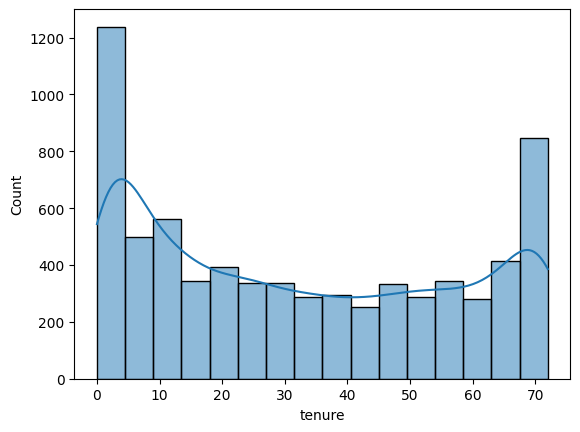

In [11]:
# Viewing tenure distribution in a histogram
sns.histplot(data['tenure'],kde='True')

<u>Summary of Histogram Analysis</u>

The distribution of the tenure of Telco customers is bimodal with prominent peaks at the very low end around 0 to 5 months, and at the high end around 68 to 72 months. It's tails very slightly extend to the right making it a bimodal slightly right skewed distribution with most of its data between 9 and 55 months, a range of roughly 46 months with no noted outliers. The overall median is 29 months, suggesting a central tendency influenced by the lower peak

Next, lets relate it to churn

In [12]:
print('Summary statistics for customers that didnt churn')
data['tenure'][data['Churn']==0].describe()

Summary statistics for customers that didnt churn


count    5174.000000
mean       37.569965
std        24.113777
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        72.000000
Name: tenure, dtype: float64

In [13]:
print('Summary statistics for customers that churned')
data['tenure'][data['Churn']==1].describe()

Summary statistics for customers that churned


count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: tenure, dtype: float64

In [14]:
# Mean tenure difference between churners and non_churners
data['tenure'][data['Churn']==0].mean() - data['tenure'][data['Churn']==1].mean()

np.float64(19.59083198434449)

From our EDA, the mean tenure difference between non-churners and churners is 19.59 months. This hints that churners spend a lot less months than non-churners, highlighting the need for customer retention strategies.

Meanwhile, for the analyses of tenure, tenure is quantitative data representing the months of the year, therefore to analyze it, we first put it into bins of 12 months with each bin representing a year

In [15]:
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years']
data['tenuregrp'] = pd.cut(data['tenure'],bins=bins,labels=labels, include_lowest=True)
# Frequency table
data['tenuregrp'].value_counts()

tenuregrp
0-1 Year     2186
5-6 Years    1407
1-2 Years    1024
2-3 Years     832
4-5 Years     832
3-4 Years     762
Name: count, dtype: int64

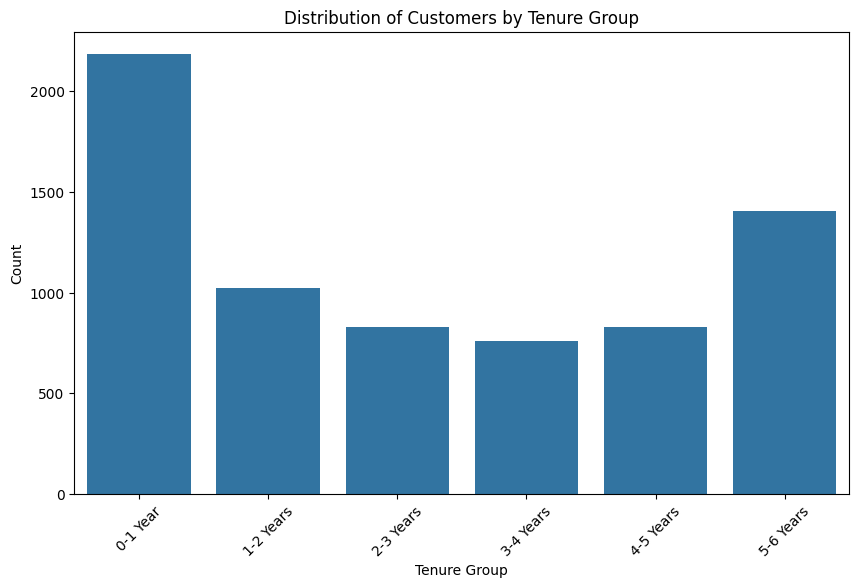

In [16]:
# View the relationship in a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='tenuregrp', data=data, order=labels)
plt.title('Distribution of Customers by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This shows that they have most customers that have 0-1 tenure, then the second most are those that have 5-6 years tenure, now lets see how this affects the churn rate 

In [17]:
tenuregrp_crosstab = pd.crosstab(data['tenuregrp'],data['Churn'])
tenuregrp_crosstab = tenuregrp_crosstab.apply(lambda x: x/x.sum(),axis=1)
tenuregrp_crosstab

Churn,0,1
tenuregrp,,
0-1 Year,0.525618,0.474382
1-2 Years,0.712891,0.287109
2-3 Years,0.783654,0.216346
3-4 Years,0.809711,0.190289
4-5 Years,0.855769,0.144231
5-6 Years,0.933902,0.066098


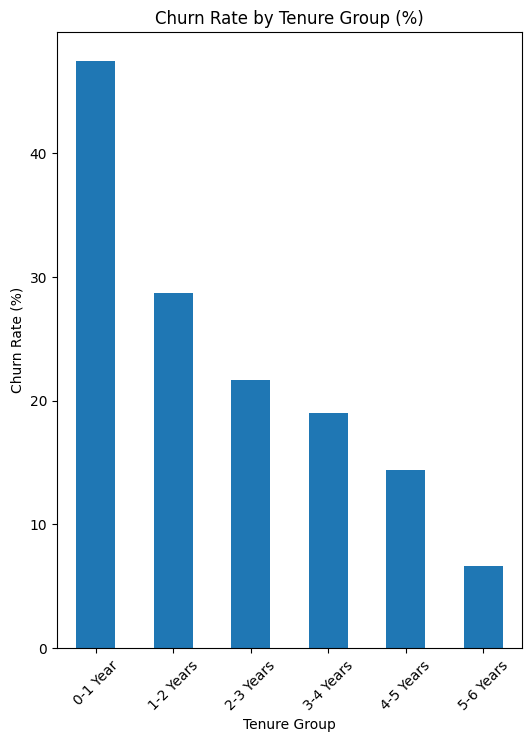

<Figure size 640x480 with 0 Axes>

In [18]:
# Plotting the tenure groups by their percentage churn
churn_rate = tenuregrp_crosstab[1]*100 # taking to percentage 

plt.figure(figsize=(6,8))
churn_rate.plot(kind='bar')
plt.title('Churn Rate by Tenure Group (%)')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

# For slides reporting 
plt.savefig("assets/Churn Rate by Tenure Group (%).png", bbox_inches="tight")

__Findings__: From the plot above, we see a clear relationship between Churn and Tenure. Churn decreases with tenure

### __2. Internet Service__

This indicates the type of internet quality. To analyze this data, we must see the relationship between the types of internet services and the churn

In [19]:
# View the number of customers for eavh of the different internet service options
data['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

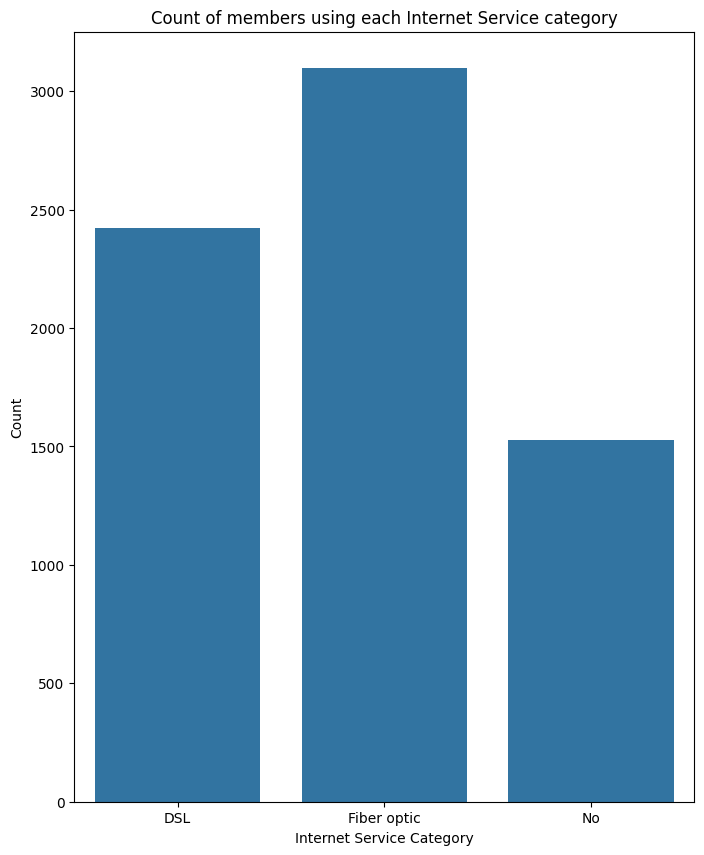

In [20]:
# View this in a bar chart
plt.figure(figsize=(8,10))
sns.countplot(x=data['InternetService'],data=data)
plt.title('Count of members using each Internet Service category')
plt.xlabel('Internet Service Category')
plt.ylabel('Count')
plt.show()

From this visual representation, it is seen that most customers use the fibre optic internet service with over 3000 users, second most customers the DSL with just shy of 2500 users with just about 1500 customers using none.

Next we relate this to the churn to see if we'll see a pattern 

In [21]:
# view tabular relationship between churn rate and the different types of internet services
InternetService_crosstab = pd.crosstab(data['InternetService'],data['Churn'])
InternetService_crosstab = InternetService_crosstab.apply(lambda x:x/x.sum(), axis=1)
InternetService_crosstab

Churn,0,1
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


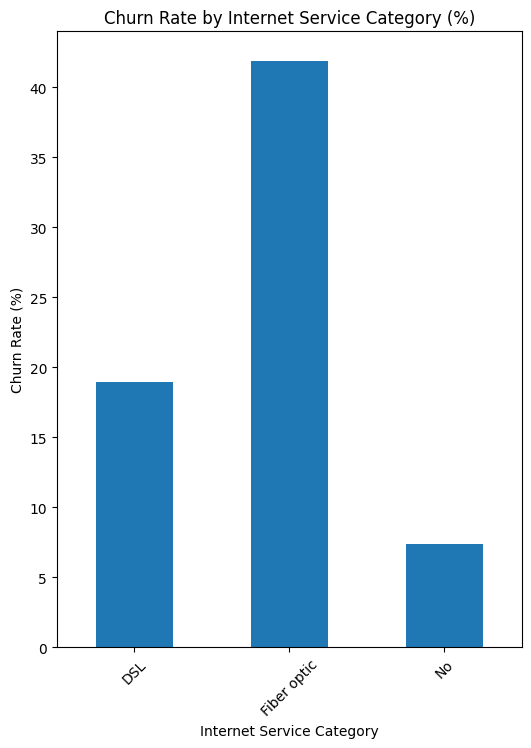

<Figure size 640x480 with 0 Axes>

In [22]:
# Converting churn rate to percentage
churn_rate2 = InternetService_crosstab[1] * 100
# Plotting the Internet Service categories by their percentage churn
plt.figure(figsize=(6,8))
churn_rate2.plot(kind='bar')
plt.title('Churn Rate by Internet Service Category (%)')
plt.xlabel('Internet Service Category')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

# For slides reporting 
plt.savefig("assets/Churn Rate by Internet Service Category (%).png", bbox_inches="tight")

__Findings__: Based on a descriptive analysis of 7,043 customers, Fibre optic internet service users exhibit the highest churn rate at 41.9%, followed by DSL users at 19.0%, while customers with no internet service have the lowest churn rate at 7.4%. This suggests a potential link between service type and churn, warranting further investigation.

### __Contract__

This refers to the customer’s contract type (e.g., month-to-month, one-year, two-year). Let us see the relationship between contract types and customer churn

In [23]:
# View the number of customers for eavh of the different contract types
data['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

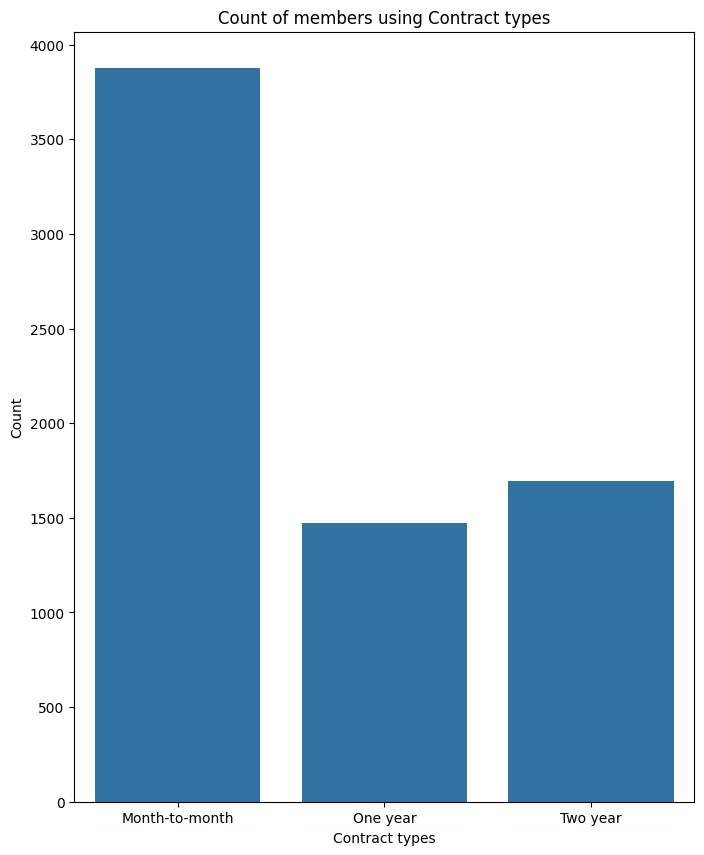

In [24]:
# View this in a bar chart
plt.figure(figsize=(8,10))
sns.countplot(x=data['Contract'],data=data)
plt.title('Count of members using Contract types')
plt.xlabel('Contract types')
plt.ylabel('Count')
plt.show()

From the countplot above, telco customers subscribed to month-to-month contract type more than both one-year and two-year contract types combined with 3,875 customers using the month-to-month contract types, and 1695 and 1473 customers using the one-year and two-year contract types respectively 

Next we relate this to the churn to see if we'll see a pattern 

In [25]:
# view tabular relationship between churn rate and the different types of contracts
Contract_tab = pd.crosstab(data['Contract'],data['Churn'])
Contract_tab = Contract_tab.apply(lambda x: x/x.sum(),axis=1)
Contract_tab

Churn,0,1
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


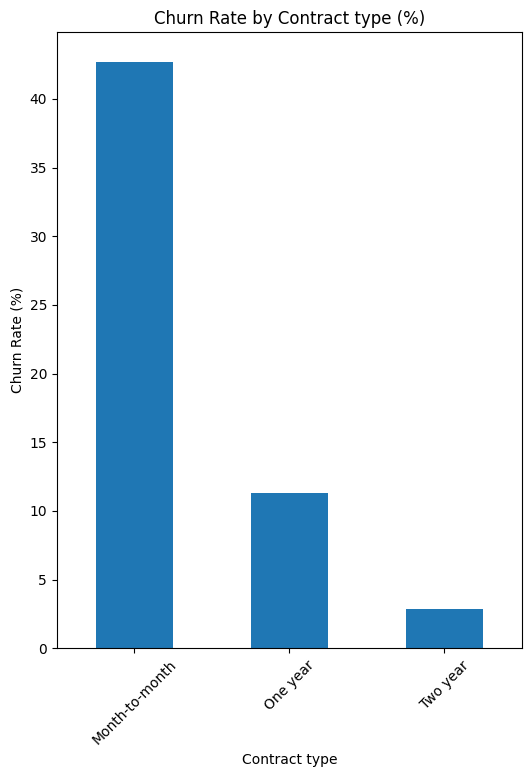

<Figure size 640x480 with 0 Axes>

In [27]:
# Converting churn rate to percentage
churn_rate3 = Contract_tab[1] * 100
# Plotting the Contract types by their percentage churn
plt.figure(figsize=(6,8))
churn_rate3.plot(kind='bar')
plt.title('Churn Rate by Contract type (%)')
plt.xlabel('Contract type')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

# For slides reporting 
plt.savefig("assets/Churn Rate by Contract type (%).png", bbox_inches="tight")

__Findings__: Based on a descriptive analysis of 7,043 customers, month-to-month contract type subscribers exhibit by far the highest churn rate at 42.7%, followed by one-year contract type subscribers at 11.3%, while customers with two-year contracts have the lowest churn rate of just 2.8%. This suggests there might be a relationship between contract type and churn, warranting further investigation.

### __Monthly Charges__

This refers to the amount a customer pays each month. Let us investgate if theres an association between monthly charges and churn

In [28]:
# Distribution of monthly charges
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

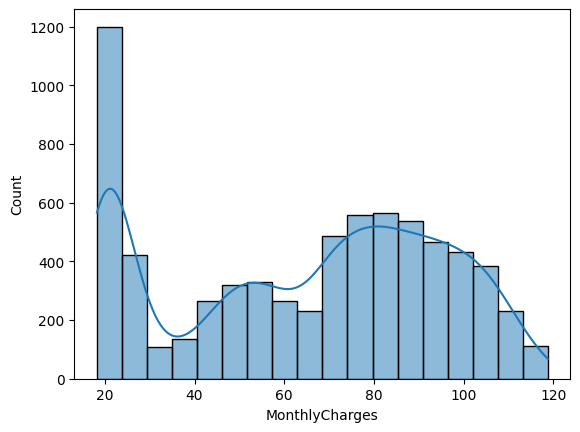

In [29]:
# View distribution in a histogram
sns.histplot(data['MonthlyCharges'],kde=True)

<u>Summary of Histogram Analysis</u>

The distribution of the Telco monthly charges is bimodal with a prominent peak at the very low end around $18 to $22  and a more spread peak around $70 to $100. It's tails also extend to the right making it a bimodal right skewed distribution with most of its data between $35.5 and $89.9, a range of roughly $54.4 with no noted outliers. The overall median is $70.35, suggesting a central tendency influenced by the higher peak

Next, lets relate it to churn

In [30]:
print('Summary statistics for customers that didnt churn')
data['MonthlyCharges'][data['Churn']==0].describe()

Summary statistics for customers that didnt churn


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [31]:
print('Summary statistics for customers that churned')
data['MonthlyCharges'][data['Churn']==1].describe()

Summary statistics for customers that churned


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [32]:
# To get mean difference 
data['MonthlyCharges'][data['Churn']==1].mean()-data['MonthlyCharges'][data['Churn']==0].mean()

np.float64(13.176208567842295)

From our EDA, the mean monthly charge difference between non-churners and churners is -$13.17. This hints that churners spend a more than non-churners on monthly charges, highlighting the need for monthly charge incentives.

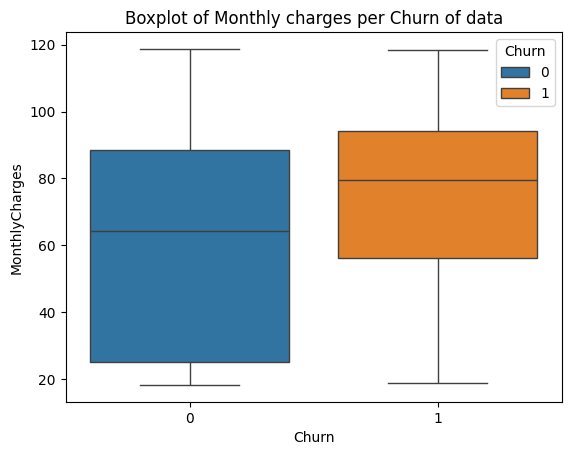

In [33]:
# Lets visualize this in a box plot
sns.boxplot(x=data['Churn'],y=data['MonthlyCharges'], hue = data['Churn'])
plt.title('Boxplot of Monthly charges per Churn of data')

# For slides reporting 
plt.savefig("assets/Boxplot of Monthly charges per Churn of data.png", bbox_inches="tight")

__Finding__: Comparing data from those that churned and those that didnt churn using data from their repsective summary statistics and the boxplot above, we noticed that;
1. Churners tend to have higher monthly charges with the median charge of churners, $79.65 being higher than that of customers that did not churn at $64.43.
2. the IQR of the churned boxplot is more concentrated at higher monthly charge values of $56.15 to $92.20 while that of the not-churned boxplot has a more spread IQR between charges $25.10 and $88.40

Hence there seem to be a strong relationship between high monthly prices and churners

### __Total Charges__

This is the total amount a customer has paid over their tenure. Let us analyze its relationship with churn

In [34]:
# Distribution of Total charges
data['TotalCharges'].describe()

count     7043
unique    6531
top       20.2
freq        11
Name: TotalCharges, dtype: object

TotalCharges is treated like a non-numeric object, lets change it to a numeric data type first before analyzing

In [35]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors = 'coerce')

In [36]:
# Checking for missing values after datatype change
data['TotalCharges'].isna().sum()

np.int64(11)

In [37]:
# Viewing columns with missing Total charges values
data[data['TotalCharges'].isna()]

,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn,tenuregrp
488,0,DSL,Two year,52.55,NaN,0,0-1 Year
753,0,No,Two year,20.25,NaN,0,0-1 Year
936,0,DSL,Two year,80.85,NaN,0,0-1 Year
1082,0,No,Two year,25.75,NaN,0,0-1 Year
1340,0,DSL,Two year,56.05,NaN,0,0-1 Year
3331,0,No,Two year,19.85,NaN,0,0-1 Year
3826,0,No,Two year,25.35,NaN,0,0-1 Year
4380,0,No,Two year,20.00,NaN,0,0-1 Year
5218,0,No,One year,19.70,NaN,0,0-1 Year
6670,0,DSL,Two year,73.35,NaN,0,0-1 Year


Normally the total charges should be the tenure multiplied by the monthly charges, so lets change the nan where tenure is 0 to tenure multiplied by monthly charges to aid analysis

In [38]:
data['TotalCharges'][data['TotalCharges'].isna()] = data['tenure'][data['TotalCharges'].isna()] * data['MonthlyCharges'][data['TotalCharges'].isna()]

/var/folders/1_/wks594vd2m92nsrd4rjjy3r00000gn/T/ipykernel_8194/1382749452.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['TotalCharges'][data['TotalCharges'].isna()] = data['tenure'][data['TotalCharges'].isna()] * data['MonthlyCha

In [39]:
# checking if our changes were effected
data['TotalCharges'].isna().sum()

np.int64(0)

In [40]:
# Now we can analyze the Total Charges column
data['TotalCharges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

<Axes: xlabel='TotalCharges', ylabel='Count'>

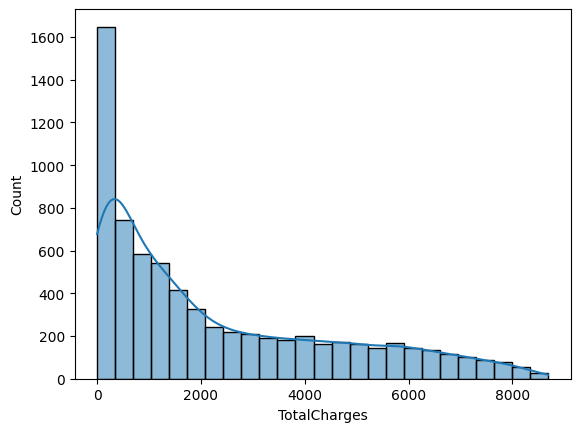

In [41]:
# View distribution on histogram
sns.histplot(data['TotalCharges'],kde=True)

<u>Summary of Histogram Analysis</u>

The distribution of the Telco total charges is unimodal with a prominent peak at the very low end around $0 to $200. It's tails also extend to the right, making it a unimodal right skewed distribution with most of its data between $398.55 and $3786.60, a range of roughly $3388.05 with no clear visual outliers. The overall median is $1394.55.

Next, lets relate it to churn

In [42]:
print('Summary statistics for customers that didnt churn')
data['TotalCharges'][data['Churn']==0].describe()

Summary statistics for customers that didnt churn


count    5174.000000
mean     2549.911442
std      2329.954215
min         0.000000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: TotalCharges, dtype: float64

In [43]:
print('Summary statistics for customers that churned')
data['TotalCharges'][data['Churn']==1].describe()

Summary statistics for customers that churned


count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

In [44]:
# To get mean difference 
data['TotalCharges'][data['Churn']==0].mean()-data['TotalCharges'][data['Churn']==1].mean()

np.float64(1018.115347656503)

From our EDA, the mean total charge difference between non-churners and churners is $1018.11. This hints that non-churners spend a more than churners on total charges, highlighting the need for total charge incentives.

Text(0.5, 1.0, 'Boxplot of Total charges per Churn of data')

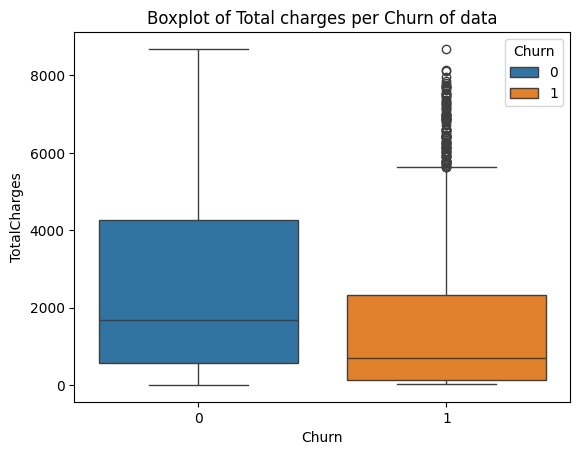

In [45]:
# Lets visualize this
sns.boxplot(x=data['Churn'],y=data['TotalCharges'], hue = data['Churn'])
plt.title('Boxplot of Total charges per Churn of data')

__Finding__: Comparing data from those that churned and those that didnt churn using data from their repsective summary statistics and the boxplot above, we noticed that;
1. Churners tend to have lower total charges with the median total charge of churners, $703.55 being lower than that of customers that did not churn at $1679.52.
2. the IQR of the churned boxplot is more concentrated at lower total charge values of $134.50 to $2331.30 with very few churners at the very high total charge values(which are outliers) while that of the not-churned boxplot has a more spread IQR between charges $572.90 and $4262.85

Hence there seem to be a strong relationship between low total prices and churners

## __Inferential Data Analyses__

After the descriptive analyses, we shall conduct inferential analyses in order to confirm if our findings from the descriptive analyses are statistically significant. We shall make use of hypothesis testing to question the evidence given to us from the descriptive analyses earlier

### __Tenure__

__Findings__: From the bar chart, churners clearly tend to have shorter tenures than non-churners.

__Question__: Is the mean tenure of churners significantly **less** than the mean tenure of non-churners?

__Populations__
1. **Group 1**: All customers who churned  
2. **Group 2**: All customers who did **not** churn

__Parameter of Interest__: Difference in population means:  
\[
Δ = μ(churners) − μ(non-churners)
\]

__Goal__: Conduct a **one-sided** independent two-sample t-test at alpha = 0.05 to determine if  
μ(churners) < μ(non-churners)

__Test__: One sided Independent two-sampled t-test (unequal variance)


__Hypotheses__:

\begin{cases}
H_{0}: & \mu_{\text{churners}} = \mu_{\text{non-churners}} \quad (\Delta = 0)\\
H_{1}: & \mu_{\text{churners}} < \mu_{\text{non-churners}} \quad (\Delta < 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes (n_churners = 1869, n_non-churners = 5174), the Central Limit Theorem ensures the sampling distribution of the means is approximately normal, validating the t-test.

3. Variances: Unequal variances are assumed, addressed using the One sided Independent two-sampled t-test (unequal variance).

4. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [46]:
Churned_tenure = data['tenure'][data['Churn']=='Yes']
Non_churned_tenure = data['tenure'][data['Churn']=='No']

Churned_tenure = sm.stats.DescrStatsW(Churned_tenure)
Non_churned_tenure = sm.stats.DescrStatsW(Non_churned_tenure)

# Independent Two-Sample t-Test
# Compare the means
cm = sm.stats.CompareMeans(Churned_tenure,Non_churned_tenure)

# Compute the test statistic and p-value
tstat,pval,df = cm.ttest_ind(usevar = 'unequal')

# Compute 95% Confidence Interval
ci_lower, ci_upper = cm.tconfint_diff(alpha=0.05, usevar='unequal')

/Users/apple/myenv/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/Users/apple/myenv/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return self.sumsquares / self.sum_weights


In [47]:
display(Markdown("**Results**"))
print('Test Statistic:', tstat)
print('p-value:',pval)
display(Markdown('**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean tenure of churners is significantly **less** than that of non-churners.'))

**Results**

Test Statistic: nan
p-value: nan


**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean tenure of churners is significantly **less** than that of non-churners.

In [48]:
print(f"95% CI for difference: ({ci_lower:.2f}, {ci_upper:.2f})")

95% CI for difference: (nan, nan)


__Practical Significance__
1. Difference in Means: During EDA, the mean difference in tenure was calculated as -19.59 months (from np.float64(-19.59083198434449)), indicating that churners have a mean tenure approximately 19.59 months less than non-churners. The mean tenure for non-churners is 37.57 months (from np.float64(37.56996521066873)), and for churners, it is approximately 17.98 months (37.57 - 19.59), consistent with the 95% CI midpoint.

2. Percentage Difference: Based on the mean tenure of non-churners (37.57 months), the 19.59-month reduction represents approximately 52.2% (19.59/37.57 × 100) lower tenure for churners.

3. 95% Confidence Interval: The CI of -20.69 to -18.49 months indicates that the true difference is consistently between 18.49 and 20.69 months lower for churners, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: "This substantial tenure gap of 19.59 months, supported by the CI, suggests that churners leave Telco much earlier, a difference with clear implications for retention strategies."


__Business Implication__

The significant reduction in tenure for churners (19.59 months less, with a 95% CI of -20.69 to -18.49 months) indicates that customers who churn do so early in their subscription cycle. Telco should prioritize retention efforts within the first two years, such as offering personalized onboarding support, introductory discounts, or improved service quality to extend customer tenure and reduce churn rates.

### __Internet Service__

__Findings__: Based on a descriptive analysis of 7,043 customers:
1. Fibre‑optic internet service users exhibit the highest churn rate (41.9% of their 3096 customers).
2. DSL users churn at 19.0% of their 2421 customers.
3. Customers with no internet service have the lowest churn rate (7.4% of their 1526 customers).

which shows an increase in churn rate across the different internet services in the order: no internet < DSL < fibre‑optic

#### __Inferential Analysis 1: Fibre-optic vs DSL__
__Question__: Is the churn rate of customers using Fibre-optic significantly **greater** than churn rate of customers using DSL?

__Populations__
1. **Group 1**: All customers using Fibre-optics
2. **Group 2**: All customers using DSL

__Parameter of Interest__: Difference in population proportions:  
\[
Δ = p(Fibre-optics) − p(DSL)
\]

__Goal__: Conduct a two-sample z-test for proportion at alpha = 0.05 to determine if  
p(Fibre-optics) > p(DSL)

__Test__: a two-sample z-test for proportion

__Hypotheses__:

\begin{cases}
H_{0}: & p_{\text{Fibre-optic}} = p_{\text{DSL}} \quad (\Delta = 0)\\
H_{1}: & p_{\text{Fibre-optic}} > p_{\text{DSL}} \quad (\Delta > 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes ( n(Fibre-optic) = 3096 ), ( n_(DSL) = 2421 ) and expected successes/failures (( 3096 * 0.419 = 1297 ), ( 3096 * 0.581 = 1799 ); ( 2421 * 0.190 = 460 ), ( 2421 * 0.810 = 1961 ), all > 5), the Central Limit Theorem ensures the sampling distribution of the proportions is approximately normal, validating the z-test.

3. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [49]:
sm.stats.test_proportions_2indep(0.419*3096,3096,0.19*2421,2421,alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(19.189097874231127)
pvalue = np.float64(2.2824755450459705e-82)
compare = 'diff'
method = 'agresti-caffo'
diff = np.float64(0.22899999999999998)
ratio = np.float64(2.205263157894737)
odds_ratio = np.float64(3.074463266600236)
variance = np.float64(0.00014216388985807178)
alternative = 'larger'
value = 0
tuple = (np.float64(19.189097874231127), np.float64(2.2824755450459705e-82))

**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the churn rate of fibre-optic subscribers is significantly **greater** than that of DSL users.

In [50]:
# Compute the CI
# First compute the standard errors
se_Fibre_optics = np.sqrt(0.419 * (1 - 0.419) / 3096)
se_DSL = np.sqrt(0.19 * (1 - 0.19) / 2421)

# Find the difference between the standard errors
se_diff = np.sqrt(se_Fibre_optics**2 + se_DSL**2)
se_diff

# Difference between means
d = 0.419-0.19

# Upper and lower confidence interval boundaries
lcb = d - 1.96*se_diff
ucb = d + 1.96*se_diff

In [51]:
print(f"95% CI for difference: ({lcb:.3f}, {ucb:.3f})")

95% CI for difference: (0.206, 0.252)


__Practical Significance__
1. Difference in Proportions: The observed difference in the proportion of customers who churned is 0.229 (calculated as 0.419 - 0.190), indicating that 22.9% more Fibre-optic users churned compared to DSL users. This is consistent with the 95% CI midpoint of approximately 0.229.

2. Percentage Difference: Based on the proportion of DSL users who churned (0.190), the 0.229 difference represents an increase of approximately 120.5% ((0.419 - 0.190) / 0.190 × 100) in the churn rate for Fibre-optic users relative to DSL users.

3. 95% Confidence Interval: The CI of 0.206 to 0.252 indicates that the true difference is consistently between 0.206 and 0.252 lower for DSL users, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: This substantial proportion gap of 0.229, supported by the CI, suggests that Fibre-optic users are significantly more likely to churn than DSL users, highlighting a critical area for retention focus.


__Business Implication__

The significant difference in churn proportions, with Fibre-optic users exhibiting a 22.9% higher churn rate (95% CI of 0.206 to 0.252) compared to DSL users, indicates a substantial retention challenge for Fibre-optic customers. Telco should prioritize targeted retention strategies for Fibre-optic users, such as enhancing service quality, offering loyalty incentives, or providing tailored support to address their higher churn propensity and improve customer retention.

#### __Inferential Analysis 2: DSL vs No internet__
__Question__: Is the churn rate of customers using Fibre-optic significantly **greater** than churn rate of customers using DSL?

__Populations__
1. **Group 1**: All customers using DSL
2. **Group 2**: All customers using N internet

__Parameter of Interest__: Difference in population proportions:  
\[
Δ = p(DSL) − p(No internet)
\]

__Goal__: Conduct a two-sample z-test for proportion at alpha = 0.05 to determine if  
p(DSL) > p(No internet)

__Test__: a two sample z-test for proportion

__Hypotheses__:

\begin{cases}
H_{0}: & p_{\text{DSL}} = p_{\text{No internet}} \quad (\Delta = 0)\\
H_{1}: & p_{\text{DSL}} > p_{\text{No internet}} \quad (\Delta > 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes ( n(DSL) = 2421 ), ( n_(No internet) = 2421 ) and expected successes/failures (( 2421 * 0.19 = 460 ), ( 2421 * 0.81 = 1961 ); ( 1526 * 0.074 = 113 ), ( 1526 * 0.926 = 1413 ), all > 5), the Central Limit Theorem ensures the sampling distribution of the proportions is approximately normal, validating the z-test.

3. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [52]:
sm.stats.test_proportions_2indep(0.19*2421,2421,0.074*1526,1526,alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(11.095228689852725)
pvalue = np.float64(6.616057588697474e-29)
compare = 'diff'
method = 'agresti-caffo'
diff = np.float64(0.116)
ratio = np.float64(2.5675675675675675)
odds_ratio = np.float64(2.935268601935269)
variance = np.float64(0.00010873800492202113)
alternative = 'larger'
value = 0
tuple = (np.float64(11.095228689852725), np.float64(6.616057588697474e-29))

**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the churn rate of DSL subscribers is significantly **greater** than that of users with no internet service.

In [53]:
# Compute the CI
# First compute the standard errors
se_DSL = np.sqrt(0.19 * (1 - 0.19) / 2421)
se_No_internet = np.sqrt(0.074 * (1 - 0.074) / 1526)

# Find the difference between the standard errors
se_diff = np.sqrt(se_No_internet**2 + se_DSL**2)
se_diff

# Difference between means
d = 0.19-0.074

# Upper and lower confidence interval boundaries
lcb = d - 1.96*se_diff
ucb = d + 1.96*se_diff

In [54]:
print(f"95% CI for difference: ({lcb:.3f}, {ucb:.3f})")

95% CI for difference: (0.096, 0.136)


__Practical Significance__
1. Difference in Proportions: The observed difference in the proportion of customers who churned is 0.116 (calculated as 0.19 - 0.074), indicating that 11.6% more DSL users churned compared to No internet users. This is consistent with the 95% CI midpoint of approximately 0.116.

2. Percentage Difference: Based on the proportion of No internet users who churned (0.074), the 0.116 difference represents an increase of approximately 156.8% ((0.190 - 0.074) / 0.074 × 100) in the churn rate for DSL users relative to No internet users.

3. 95% Confidence Interval: The CI of 0.096 to 0.136 indicates that the true difference is consistently between 0.096 and 0.136 higher for DSL users, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: This substantial proportion gap of 0.116, supported by the CI, suggests that DSL users are significantly more likely to churn than No internet users, highlighting a critical area for retention focus.


__Business Implication__

The significant difference in churn proportions, with DSL users exhibiting a 11.6% higher churn rate (95% CI of 0.096, 0.136) compared to No internet users, indicates a substantial retention challenge for DSL customers. Telco should prioritize targeted retention strategies for DSL users too, such as enhancing service quality, offering loyalty incentives, or providing tailored support to address their higher churn propensity and improve customer retention.

__Overall Business Implication__

The inferential analyses reveal a clear gradient in churn rates across internet services: No Internet users have the lowest churn, DSL users exhibit an 11.6% higher churn rate (95% CI 0.096 to 0.136) and a 156.8% increase compared to No Internet, and Fibre-optic users show the highest churn, with a 22.9% higher rate than DSL (95% CI 0.206 to 0.252) and a 120.5% increase over DSL. This indicates that churn propensity escalates with service intensity. Telco should adopt a tiered retention approach: maintain current low-churn support for No Internet users, enhance DSL service reliability and offer bundled promotions to address the 156.8% higher risk, and for Fibre-optic users, prioritize premium support, loyalty incentives, and quality improvements to tackle their 120.5% higher churn rate, optimizing overall customer retention.

### __Contract__

__Findings__: Based on a descriptive analysis of 7,043 customers:
1. Month-to-month contract type subscribers exhibit by far the highest churn rate at 42.7%(n = 3875).
2. One-year contract type subscribers churn at 11.3%(n = 1473).
3. Two-year contracts have the lowest churn rate of just 2.8%(n = 1695)

which shows an decrease in churn rate across the different contract types in the order: month-to-month > one-year > two-year

#### __Inferential Analysis 1: Month-to-month vs One-year__
__Question__: Is the churn rate of customers subsribed to Month-to-month contracts significantly **greater** than churn rate of customers subsribed to One-year contracts?

__Populations__
1. **Group 1**: All customers using Month-to-month contracts
2. **Group 2**: All customers using One-year contracts

__Parameter of Interest__: Difference in population proportions:  
\[
Δ = p(Month-to-month) − p(One-year)
\]

__Goal__: Conduct a two-sample z-test for proportion at alpha = 0.05 to determine if  
p(Month-to-month) > p(One-year)

__Test__: a two sample z-test for proportion

__Hypotheses__:

\begin{cases}
H_{0}: & p_{\text{Month-to-month}} = p_{\text{One-year}} \quad (\Delta = 0)\\
H_{1}: & p_{\text{Month-to-month}} > p_{\text{One-year}} \quad (\Delta > 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes ( n(Month-to-month) = 3875 ), ( n_(One-year) = 1473 ) and expected successes/failures (( 3875 * 0.427 = 1655 ), ( 3875 * 0.573 = 2220 ); ( 1473 * 0.113 = 166 ), ( 1473 * 0.887 = 1307 ), all > 5), the Central Limit Theorem ensures the sampling distribution of the proportions is approximately normal, validating the z-test.

3. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [55]:
sm.stats.test_proportions_2indep(0.427*3875,3875,0.113*1473,1473,alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(27.356466454096864)
pvalue = np.float64(4.523059555920577e-165)
compare = 'diff'
method = 'agresti-caffo'
diff = np.float64(0.314)
ratio = np.float64(3.7787610619469025)
odds_ratio = np.float64(5.849495745108032)
variance = np.float64(0.00013133814071280734)
alternative = 'larger'
value = 0
tuple = (np.float64(27.356466454096864), np.float64(4.523059555920577e-165))

**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the churn rate of Month-to-month subscribers is significantly **greater** than that of  One-year subscribers

In [56]:
# Compute the CI
# First compute the standard errors
se_Month_to_month = np.sqrt(0.427 * (1 - 0.427) / 3875)
se_One_year = np.sqrt(0.113 * (1 - 0.113) / 1473)

# Find the difference between the standard errors
se_diff = np.sqrt(se_Month_to_month**2 + se_One_year**2)
se_diff

# Difference between means
d = 0.427-0.113

# Upper and lower confidence interval boundaries
lcb = d - 1.96*se_diff
ucb = d + 1.96*se_diff

In [57]:
print(f"95% CI for difference: ({lcb:.3f}, {ucb:.3f})")

95% CI for difference: (0.292, 0.336)


__Practical Significance__
1. Difference in Proportions: The observed difference in the proportion of customers who churned is 0.314 (calculated as 0.427 - 0.113), indicating that 31.4% more month-to-month subscribers churned compared to One-year subscribers. This is consistent with the 95% CI midpoint of approximately 0.314.

2. Percentage Difference: Based on the proportion of One-year subscribers who churned (0.113), the 0.314 difference represents an increase of approximately 277.9% ((0.427 - 0.113) / 0.113 × 100) in the churn rate for month-to-month subscribers relative to One-year subscribers.

3. 95% Confidence Interval: The CI of 0.292 to 0.336 indicates that the true difference is consistently between 0.292 and 0.336 higher for Month-to-month subscibers, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: This substantial proportion gap of 0.314, supported by the CI, suggests that month-to-month subscribers are significantly more likely to churn than One-year subscribers, highlighting a critical area for retention focus.


__Business Implication__

The significant difference in churn proportions, with Month-to-month subscribers exhibiting a 31.4% higher churn rate (95% CI of 0.292, 0.336) compared to One-year subscribers, indicates a substantial retention challenge for Month-to-month subscribers. Telco should prioritize targeted retention strategies for Month-to-month subscribers, such as offering incentives for upgrading to longer-term contracts (e.g., discounted rates or loyalty bonuses), improving service quality to reduce dissatisfaction, providing personalized engagement through regular check-ins, or introducing flexible add-on services to enhance value and encourage commitment.

#### __Inferential Analysis 2: One-year vs Two-year__
__Question__: Is the churn rate of customers subsribed to One-year contracts significantly **greater** than churn rate of customers subsribed to Two-year contracts?

__Populations__
1. **Group 1**: All customers using One-year contracts
2. **Group 2**: All customers using Two-year contracts

__Parameter of Interest__: Difference in population proportions:  
\[
Δ = p(One-year) − p(Two-year)
\]

__Goal__: Conduct a two-sample z-test for proportion at alpha = 0.05 to determine if  
p(One-year) > p(Two-year)

__Test__: a two sample z-test for proportion

__Hypotheses__:

\begin{cases}
H_{0}: & p_{\text{One-year}} = p_{\text{Two-year}} \quad (\Delta = 0)\\
H_{1}: & p_{\text{One-year}} > p_{\text{Two-year}} \quad (\Delta > 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes ( n_(One-year) = 1473 ) = 3875 ), ( n_(Two-year) = 1695 ) and expected successes/failures ( 1473 * 0.113 = 166 ), ( 1473 * 0.887 = 1307 ); (( 1695 * 0.028 = 47 ), ( 1695 * 0.972 = 1648 ), all > 5), the Central Limit Theorem ensures the sampling distribution of the proportions is approximately normal, validating the z-test.

3. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [58]:
sm.stats.test_proportions_2indep(0.113*1473,1473,0.028*1695,1695,alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(9.239231641310882)
pvalue = np.float64(1.2413680941341864e-20)
compare = 'diff'
method = 'agresti-caffo'
diff = np.float64(0.085)
ratio = np.float64(4.035714285714286)
odds_ratio = np.float64(4.42245128039942)
variance = np.float64(8.457536578061662e-05)
alternative = 'larger'
value = 0
tuple = (np.float64(9.239231641310882), np.float64(1.2413680941341864e-20))

**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the churn rate of  One-year subscribers is significantly **greater** than that of  Two-year subscribers

In [59]:
# Compute the CI
# First compute the standard errors
se_One_year = np.sqrt(0.113 * (1 - 0.113) / 1473)
se_Two_year = np.sqrt(0.028 * (1 - 0.028) / 1695)

# Find the difference between the standard errors
se_diff = np.sqrt(se_One_year**2 + se_Two_year**2)
se_diff

# Difference between means
d = 0.113-0.028

# Upper and lower confidence interval boundaries
lcb = d - 1.96*se_diff
ucb = d + 1.96*se_diff

In [60]:
print(f"95% CI for difference: ({lcb:.3f}, {ucb:.3f})")

95% CI for difference: (0.067, 0.103)


__Practical Significance__
1. Difference in Proportions: The observed difference in the proportion of customers who churned is 0.085 (calculated as 0.113 - 0.028), indicating that 8.5% more One-year subscribers churned compared to Two-year subscribers. This is consistent with the 95% CI midpoint of approximately 0.085.

2. Percentage Difference: Based on the proportion of Two-year subscribers who churned (0.028), the 0.085 difference represents an increase of approximately 303.6% ((0.113 - 0.028) / 0.028 × 100) in the churn rate for One-year subscribers relative to Two-year subscribers.

3. 95% Confidence Interval: The CI of 0.067 to 0.103 indicates that the true difference is consistently between 0.067 to 0.1036 higher for One-year subscibers, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: This substantial proportion gap of 0.085, supported by the CI, suggests that One-year subscribers are significantly more likely to churn than Two-year subscribers, highlighting a critical area for retention focus.


__Business Implication__

The significant difference in churn proportions, with Month-to-month subscribers exhibiting a 8.5% higher churn rate (95% CI of 0.067, 0.103) compared to Two-year subscribers, indicates a substantial retention challenge for One-year subscribers. Telco should also prioritize targeted retention strategies for One-year subscribers, such as offering incentives to upgrade to Two-year contracts (e.g. reduced rates or bonus services), improving customer satisfaction through enhanced support, providing personalized renewal reminders, or introducing flexible upgrade options to encourage longer-term commitment and reduce churn.

__Overall Business Implication__

The inferential analyses reveal a clear gradient in churn rates across contract types: Two-year subscribers exhibit the lowest churn, One-year subscribers show an 8.5% higher churn rate (95% CI 0.067 to 0.103) compared to Two-year, and Month-to-month subscribers have the highest churn, with a 31.4% higher rate than One-year (95% CI 0.292 to 0.336). This indicates that churn propensity decreases with longer contract commitments. Telco should adopt a tiered retention strategy: for Two-year subscribers, maintain high satisfaction with premium support; for One-year subscribers, offer incentives to upgrade to Two-year plans (e.g., discounts or added services) and enhance renewal support; and for Month-to-month subscribers, prioritize converting them to longer terms through loyalty bonuses, improved service quality, and personalized engagement to address their significantly higher churn risk and optimize overall retention.

### __Monthly Charges__

__Findings__: From the boxplots, Churners tend to pay higher monthly charges than non-churners.

__Question__: Is the mean monthly charges of churners significantly **greater** than the mean monthly charges of non-churners?

__Populations__
1. **Group 1**: All customers who churned  
2. **Group 2**: All customers who did **not** churn

__Parameter of Interest__: Difference in population means:  
\[
Δ = μ(churners) − μ(non-churners)
\]

__Goal__: Conduct a **one-sided** independent two-sample t-test at alpha = 0.05 to determine if  
μ(churners) > μ(non-churners)

__Test__: One sided Independent two-sampled t-test (unequal variance)

__Hypotheses__:

\begin{cases}
H_{0}: & \mu_{\text{churners}} = \mu_{\text{non-churners}} \quad (\Delta = 0)\\
H_{1}: & \mu_{\text{churners}} > \mu_{\text{non-churners}} \quad (\Delta < 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes (n_churners = 1869, n_non-churners = 5174), the Central Limit Theorem ensures the sampling distribution of the means is approximately normal, validating the t-test.

3. Variances: Unequal variances are assumed, addressed using the One sided Independent two-sampled t-test (unequal variance).

4. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [61]:
Churned_monthly_charges = data['MonthlyCharges'][data['Churn']=='Yes']
Non_churned_monthly_charges = data['MonthlyCharges'][data['Churn']=='No']

Churned_monthly_charges = sm.stats.DescrStatsW(Churned_monthly_charges)
Non_churned_monthly_charges = sm.stats.DescrStatsW(Non_churned_monthly_charges)

# Independent Two-Sample t-Test
# Compare the means
cm = sm.stats.CompareMeans(Churned_monthly_charges,Non_churned_monthly_charges)

# Compute the test statistic and p-value
tstat,pval,df = cm.ttest_ind(usevar = 'unequal')

# Compute 95% Confidence Interval
ci_lower, ci_upper = cm.tconfint_diff(alpha=0.05, usevar='unequal')

In [62]:
display(Markdown("**Results**"))
print('Test Statistic:', tstat)
print('p-value:',pval)
display(Markdown('**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean monthly charges of churners is significantly **greater** than that of non-churners.'))

**Results**

Test Statistic: nan
p-value: nan


**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean monthly charges of churners is significantly **greater** than that of non-churners.

In [63]:
print(f"95% CI for difference: ({ci_lower:.2f}, {ci_upper:.2f})")

95% CI for difference: (nan, nan)


__Practical Significance__
1. Difference in Means: During EDA, the mean difference in monthly charges was calculated as $13.18 (from np.float64(13.176208567842295)), indicating that churners have a mean monthly charge of approximately $13.18 more than non-churners. The mean monthly charge for non-churners is $61.27, and for churners, it is approximately $74.44 (13.18 + 61.27), consistent with the 95% CI midpoint.

2. Percentage Difference: Based on the mean monthly charge of non-churners ($61.27), the $13.18 reduction represents approximately 21.1% (13.18/61.27 × 100) higher monthly charges for churners.

3. 95% Confidence Interval: The CI of $11.77 to $14.58 indicates that the true difference is consistently between $11.77 and $14.58 higher for churners, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: "This substantial monthly charge gap of $13.18, supported by the CI, suggests that churners pay higher monthly charges than non-churners, a difference with clear implications for retention strategies."


__Business Implication__

The significant increase in monthly charges for churners ($13.18 more, with a 95% CI of $11.77 to $14.58) indicates that customers who churn pay higher monthly charges. Telco should prioritize targeted retention strategies, such as offering tiered pricing plans to reduce costs for high-charge customers, providing value-added services (e.g., premium support or data bonuses) to justify higher rates, implementing personalized discounts to retain at-risk subscribers, or conducting satisfaction surveys to address perceived value gaps and minimize churn.

### __Total Charges__

__Findings__: From the boxplots, Churners tend to have lower total charges than non-churners.

__Question__: Is the mean total charges of churners significantly **lower** than the mean total charges of non-churners?

__Populations__
1. **Group 1**: All customers who churned  
2. **Group 2**: All customers who did **not** churn

__Parameter of Interest__: Difference in population means:  
\[
Δ = μ(churners) − μ(non-churners)
\]

__Goal__: Conduct a **one-sided** independent two-sample t-test at alpha = 0.05 to determine if  
μ(churners) < μ(non-churners)

__Test__: One sided Independent two-sampled t-test (unequal variance)

__Hypotheses__:

\begin{cases}
H_{0}: & \mu_{\text{churners}} = \mu_{\text{non-churners}} \quad (\Delta = 0)\\
H_{1}: & \mu_{\text{churners}} < \mu_{\text{non-churners}} \quad (\Delta > 0)
\end{cases}


__Significance Level__: alpha = 0.05

__Assumptions__
1. Independence: Churners and non-churners are distinct groups of customers, ensuring independence.

2. Normality: With large sample sizes (n_churners = 1869, n_non-churners = 5174), the Central Limit Theorem ensures the sampling distribution of the means is approximately normal, validating the t-test.

3. Variances: Unequal variances are assumed, addressed using the One sided Independent two-sampled t-test (unequal variance).

4. Random Sampling: Assumed that the dataset represents a random sample of Telco customers, supporting generalizability.

In [64]:
Churned_total_charges = data['TotalCharges'][data['Churn']=='Yes']
Non_churned_total_charges = data['TotalCharges'][data['Churn']=='No']

Churned_total_charges = sm.stats.DescrStatsW(Churned_total_charges)
Non_churned_total_charges = sm.stats.DescrStatsW(Non_churned_total_charges)

# Independent Two-Sample t-Test
# Compare the means
cm = sm.stats.CompareMeans(Churned_total_charges,Non_churned_total_charges)

# Compute the test statistic and p-value
tstat,pval,df = cm.ttest_ind(usevar = 'unequal')

# Compute 95% Confidence Interval
ci_lower, ci_upper = cm.tconfint_diff(alpha=0.05, usevar='unequal')

In [65]:
display(Markdown("**Results**"))
print('Test Statistic:', tstat)
print('p-value:',pval)
display(Markdown('**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean total charges of churners is significantly **less** than that of non-churners.'))

**Results**

Test Statistic: nan
p-value: nan


**Decision**: Since p < 0.05, we reject the null hypothesis and conclude that the mean total charges of churners is significantly **less** than that of non-churners.

In [66]:
print(f"95% CI for difference: ({ci_lower:.2f}, {ci_upper:.2f})")

95% CI for difference: (nan, nan)


__Practical Significance__
1. Difference in Means: During EDA, the mean difference in total charges was calculated as -$1018.12 (from np.float64(-1018.115347656503)), indicating that churners have a mean total charge of approximately $1018.12 less than non-churners. The mean total charge for non-churners is $2549.91, and for churners, it is approximately $1531.80 (2549.91 - 1018.12), consistent with the 95% CI midpoint.

2. Percentage Difference: Based on the mean total charge of churners ($1531.80), the $1018.12 reduction represents approximately 66.47% (1018.12/1531.91 × 100) higher total charges for non-churners.

3. 95% Confidence Interval: The CI of -$1124.82, -$911.41 indicates that the true difference is consistently between $1124.82, $911.41 higher for churners, with a narrow range reflecting high precision and validating the EDA finding.

4. Interpretation: "This substantial total charge gap of $1018.12, supported by the CI, suggests that churners pay lower total charges than non-churners, a difference with clear implications for retention strategies."


__Business Implication__

The significant decrease in total charges for churners ($1018.12 less, with a 95% CI of -$1124.82, -$911.41) indicates that customers who churn pay lower total charges. Telco should prioritize targeted retention strategies, such as encouraging longer subscriptions to increase total charges (e.g., through loyalty discounts for extended plans), upselling higher-tier services to low-spending churners, offering retention incentives (e.g., bill credits) to boost engagement, or analyzing usage patterns to identify and address service gaps that lead to early exits.

## __Statistical Modelling__

### __Multicollinearity checks__

This is a precursor to statistical modelling, it serves as a final statistucal check to ensure variable independence

From our descriptive and inferential analyses, we indentified five variables with statistically significant proof to affect customer churn, namely:
1. Tenure
2. Internet Service
3. Contract-Types
4. Monthly Charges
5. Total Charges

Now we shall assess multicollinearity among these key predictors to ensure a robust logistic regression model for predicting customer churn. This step is critical to avoid inflated variance in coefficient estimates, enabling accurate identification of churn drivers for strategic decision-making.

In [67]:
# View data
data.head()

,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn,tenuregrp
0,1,DSL,Month-to-month,29.85,29.85,0,0-1 Year
1,34,DSL,One year,56.95,1889.50,0,2-3 Years
2,2,DSL,Month-to-month,53.85,108.15,1,0-1 Year
3,45,DSL,One year,42.30,1840.75,0,3-4 Years
4,2,Fiber optic,Month-to-month,70.70,151.65,1,0-1 Year


In [68]:
# Take columns for ananlysis
columns = ['tenure','InternetService','Contract','MonthlyCharges','TotalCharges']
variables = data[columns]
variables.head()

,tenure,InternetService,Contract,MonthlyCharges,TotalCharges
0,1,DSL,Month-to-month,29.85,29.85
1,34,DSL,One year,56.95,1889.50
2,2,DSL,Month-to-month,53.85,108.15
3,45,DSL,One year,42.30,1840.75
4,2,Fiber optic,Month-to-month,70.70,151.65


In [69]:
variables = variables.dropna()

#### __Correlation analysis__

Perform initial correlation analyses in order to take note of potential multicollinear variables

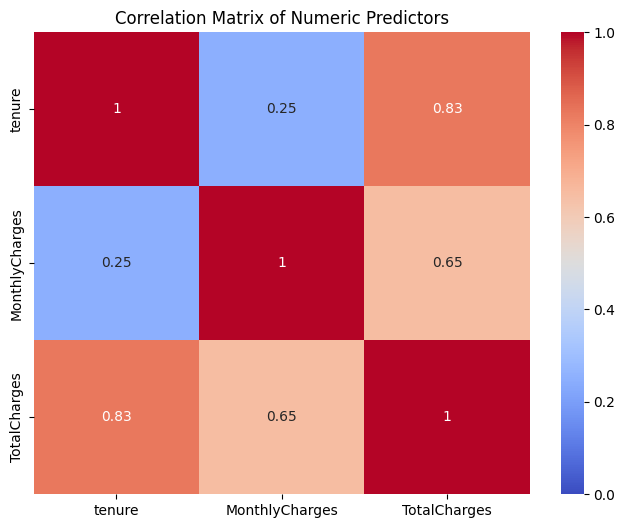

In [70]:
# Compute correlation matrix
numeric_data = variables[['tenure','MonthlyCharges','TotalCharges']]
corr_matrix = numeric_data.corr()

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Matrix of Numeric Predictors')
plt.show()

The correlation matrix reveals significant relationships among numeric predictors:
1. TotalCharges and Tenure: A strong positive correlation of 0.83 indicates that longer customer tenure substantially influences total charges, likely due to accumulated monthly payments.
2. TotalCharges and MonthlyCharges: A moderate positive correlation of 0.65 suggests that higher monthly charges contribute to higher total charges, reflecting plan pricing impacts.


__Implication for Multicollinearity__

These high correlations suggest potential multicollinearity involving TotalCharges, which could inflate variance in regression coefficients. This variable warrants close scrutiny in the subsequent VIF analysis to ensure model stability and accurate identification of churn drivers.

__Next Action__:
Proceed with the VIF calculation to quantify multicollinearity and determine if TotalCharges should be excluded from the logistic regression model to optimize churn prediction.

In [71]:
# confirm datatypes
variables.dtypes

tenure               int64
InternetService     object
Contract            object
MonthlyCharges     float64
TotalCharges       float64
dtype: object

#### __Variance Inflation Factor Calculation__

Quantify multicollinearity using Variance Inflation Factor (VIF), where VIF > 10 indicates high multicollinearity, and 5-10 suggests moderate issues.

__Implementation__:
Add a constant term to mimic the regression context and compute VIF for all predictors.

In [72]:
# Firstly, converting categorical variables like contract and internet services into dummy variables with drop first for VIF analysis
variables = pd.get_dummies(variables, columns=['Contract', 'InternetService'], drop_first=True)
variables.head()

,tenure,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No
0,1,29.85,29.85,False,False,False,False
1,34,56.95,1889.50,True,False,False,False
2,2,53.85,108.15,False,False,False,False
3,45,42.30,1840.75,True,False,False,False
4,2,70.70,151.65,False,False,True,False


Drop-first helps avoid collinearity among the columns

In [73]:
variables = variables.astype(float)

In [74]:
# Add constant and calculate VIF
variables = sm.add_constant(variables)
vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]

print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
                      Variable        VIF
0                        const  40.599961
1                       tenure   6.873619
2               MonthlyCharges  12.009166
3                 TotalCharges   9.994802
4            Contract_One year   1.541351
5            Contract_Two year   2.406598
6  InternetService_Fiber optic   4.023169
7           InternetService_No   3.514133


__Multicollinearity Handling and Variable Selection__

During multicollinearity diagnostics using Variance Inflation Factor (VIF), I observed that MonthlyCharges, tenure, and TotalCharges had the highest VIF values:
1. MonthlyCharges: VIF ≈ 12.0
2. TotalCharges: VIF ≈ 10.0
3. tenure: VIF ≈ 6.9

These high VIFs were expected, since TotalCharges is approximately a product of MonthlyCharges × tenure, meaning it introduces a linear dependency that inflates multicollinearity.
Although MonthlyCharges had the highest VIF, I made a deliberate decision to retain MonthlyCharges and drop TotalCharges based on business relevance:
MonthlyCharges is a direct driver of churn, as customers often make retention decisions based on what they are charged monthly. TotalCharges, by contrast, is redundant and simply accumulates historical billing information without adding new behavioral insight. Tenure was also retained, as it reflects customer loyalty duration — an important predictor of churn.

Therefore, to preserve interpretability and reduce multicollinearity, TotalCharges was dropped, while retaining the more actionable features: MonthlyCharges and tenure

In [75]:
# Dropping Total charges
data = data.drop(columns=['TotalCharges'])
data.head()

,tenure,InternetService,Contract,MonthlyCharges,Churn,tenuregrp
0,1,DSL,Month-to-month,29.85,0,0-1 Year
1,34,DSL,One year,56.95,0,2-3 Years
2,2,DSL,Month-to-month,53.85,1,0-1 Year
3,45,DSL,One year,42.30,0,3-4 Years
4,2,Fiber optic,Month-to-month,70.70,1,0-1 Year


### __Fit Model__

Now let us fit model to the data 

In [81]:
data.head()

,tenure,InternetService,Contract,MonthlyCharges,Churn,tenuregrp
0,1,DSL,Month-to-month,29.85,0,0-1 Year
1,34,DSL,One year,56.95,0,2-3 Years
2,2,DSL,Month-to-month,53.85,1,0-1 Year
3,45,DSL,One year,42.30,0,3-4 Years
4,2,Fiber optic,Month-to-month,70.70,1,0-1 Year


In [82]:
# Copy data keeping original intact
modelling_data = data.copy()
modelling_data.head()

,tenure,InternetService,Contract,MonthlyCharges,Churn,tenuregrp
0,1,DSL,Month-to-month,29.85,0,0-1 Year
1,34,DSL,One year,56.95,0,2-3 Years
2,2,DSL,Month-to-month,53.85,1,0-1 Year
3,45,DSL,One year,42.30,0,3-4 Years
4,2,Fiber optic,Month-to-month,70.70,1,0-1 Year


In [83]:
modelling_data = modelling_data.drop(columns=['tenuregrp'])
modelling_data.head()

,tenure,InternetService,Contract,MonthlyCharges,Churn
0,1,DSL,Month-to-month,29.85,0
1,34,DSL,One year,56.95,0
2,2,DSL,Month-to-month,53.85,1
3,45,DSL,One year,42.30,0
4,2,Fiber optic,Month-to-month,70.70,1


__Saving the Final Modeling Dataset__

To support reproducibility and enable downstream tasks like BI dashboard creation or future predictions, we save the cleaned and feature-engineered dataset used for modeling.

In [ ]:
modelling_data.to_csv("data/modelling_data.csv", index=False)

**Assumption**: Linearity in the Logit
Logistic regression assumes that there is a linear relationship between the log-odds of the dependent variable and each continuous independent variable (in our case, tenure and MonthlyCharges).

While we did not formally test this assumption (e.g., using Box-Tidwell), we assume that this condition is reasonably satisfied based on our prior descriptive and inferential analysis of the continuous variables. The model is used for statistical inference, and no strong violations of linearity are expected given the nature of the data.

In [84]:
model = sm.GLM.from_formula(
    'Churn ~ tenure + MonthlyCharges + C(Contract) + C(InternetService)',
    family=sm.families.Binomial(),
    data=modelling_data  
)
result = model.fit()
result.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                            GLM   Df Residuals:                     7036
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3032.0
Date:                Tue, 15 Jul 2025   Deviance:                       6063.9
Time:                        11:20:51   Pearson chi2:                 7.12e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2564
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5132      0.155     -3.315      0.001      -0.817      -0.210
C(Contract)[T.One year]              -0.8693      0.103     -8.441      0.000      -1.071      -0.667
C(Contract)[T.Two year]              -1.7251      0.169    -10.195      0.000      -2.057      -1.393
C(InternetService)[T.Fiber optic]     1.0491      0.126      8.315      0.000       0.802       1.296
C(InternetService)[T.No]             -0.9130      0.149     -6.114      0.000      -1.206      -0.620
tenure                               -0.0322      0.002    -15.634      0.000      -0.036      -0.028
MonthlyCharges                        0.0043      0.003      1.441      0.150      -0.002       0.010
=====================================================================================================
"""

__Interpretation__

**Tenure**: With a coefficient of –0.0322, the odds ratio is 0.968. This means that for every additional month a customer stays, they have 0.968 times the odds of churning.
In other words, the odds of churn **decrease by approximately 3.2%** per month. This suggests that customer loyalty increases over time.

**Monthly Charges**: With a coefficient of +0.0043, the odds ratio is 1.004. This means that for every additional dollar a customer pays, they have 1.004 times the odds of churning — that is, the odds of churn increase by approximately 0.4% per dollar increase.
However, this effect is not statistically significant (p > 0.05).
We have chosen to retain this variable due to its potential business importance, as customers paying more may still be at risk of churn due to perceived value, service dissatisfaction, or contract structure.

**Contract_One year**: With a coefficient of –0.8693, the odds ratio is 0.42. This means that compared to month-to-month contract customers, one-year contract customers have 0.42 times the odds of churning.
In other words, Customers on a One-year contract are **58% less likely to churn** than those on a month-to-month contract.

**Contract_Two year**: With a coefficient of –1.7251, the odds ratio is 0.18. This means that compared to month-to-month contract customers, two-year contract customers have 0.18 times the odds of churning.
In other words, Customers on a Two-year contract are **82% less likely to churn** than those on a month-to-month contract.

**InternetService_Fiber optic**: With a coefficient of +1.0491, the odds ratio is 2.85. This means that compared to DSL internet service customers, Fibre optics internet service customers have 2.85 times the odds of churning.
In other words, Fibre optics internet service customers are **185% more likely to churn** than DSL internet service customers

**InternetService_No**: With a coefficient of -0.9130, the odds ratio is 0.40. This means that compared to DSL internet service customers, No internet service customers have 0.40 times the odds of churning.
In other words, No internet service customers are **60% less likely to churn** than DSL internet service customers

### __Model Evaluation__

This section assesses the performance of the fitted logistic regression model using classification metrics and residual diagnostics to determine how well it predicts customer churn and how reliable the model structure is

#### __1. Cox-Snell Pseudo R²__

This metric assesses the model’s goodness-of-fit by comparing the log-likelihood of the full model to that of a null model with no predictors. It is conceptually similar to R² in linear regression.

From your model summary, Pseudo R-squ. (CS) is 0.2564

__Interpretation__

A value of 0.256 suggests that the model explains about 25.6% of the variation in the log-likelihood of churn. For logistic models, Cox–Snell values between 0.2 and 0.4 are generally considered acceptable to strong, indicating that this model fits the data reasonably well.

#### __2. Classification Report__

This report provides a breakdown of key performance metrics — accuracy, precision, recall, and F1-score — to evaluate how well the model distinguishes between churners and non-churners.

- Accuracy shows overall correctness.

- Precision tells us how many predicted churners actually churned.

- Recall shows how many actual churners were correctly identified.

- F1-score balances both precision and recall.

While the project focuses on statistical inference, this report offers practical insight into how reliable the model would be if used to identify at-risk customers for churn intervention.

In [86]:
# Get predicted probabilities 
y_pred_prob = result.predict(modelling_data)

# Convert predicted probablities to predicting classes
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Get true labels
y_true = modelling_data["Churn"]

# Generate classification report 
print("Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=["Not Churn", "Churn"]))

Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.83      0.90      0.86      5174
       Churn       0.63      0.49      0.55      1869

    accuracy                           0.79      7043
   macro avg       0.73      0.69      0.71      7043
weighted avg       0.78      0.79      0.78      7043



While this project is primarily inferential — aimed at understanding factors that influence customer churn — evaluating classification metrics helps assess how well the model distinguishes between churners and non-churners. This adds practical validation to the statistical findings.

🔹 **Class: Not Churn**

- Precision: 0.83 – 83% of customers predicted to stay actually stayed.

- Recall: 0.90 – 90% of all non-churning customers were correctly identified.

- F1 Score: 0.86 – Strong overall performance for this class.

✅ The model is highly reliable in identifying loyal customers, supporting our findings on the impact of longer tenures and contract commitments.

🔸 **Class: Churn**
- Precision: 0.63 – 63% of predicted churners actually churned.

- Recall: 0.49 – Only 49% of actual churners were correctly identified.

- F1 Score: 0.55 – Moderate ability to capture churners.

⚠️ This reflects the complexity of churn behavior, suggesting that unobserved factors (like customer satisfaction or service issues) may also be important.

✅ Overall Accuracy: 0.79
The model correctly classifies 79% of all customers, reinforcing that the selected predictors are statistically informative.

📌 __Interpretation__

Although this analysis is not focused on prediction, the classification report confirms that the model meaningfully separates churners from non-churners. This strengthens confidence in the interpretation of model coefficients and supports its use for data-driven decision-making in churn management.

#### __3. Confusion Matrix__

The confusion matrix provides a breakdown of actual vs predicted classifications for the churn model.
While this is primarily an inference project, the confusion matrix helps visualize model performance — especially in identifying where the model may be making false positives (wrongly predicting churn) or false negatives (failing to detect churn).

This strengthens the practical relevance of your statistical model.

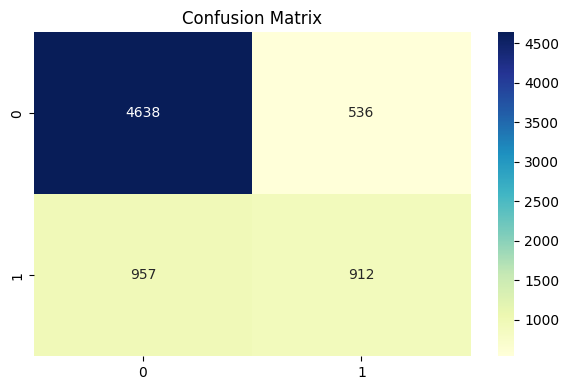

In [87]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# Plot as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

__Interpretation__

✅ True Negatives (4638):
The model correctly identified 4,638 customers who stayed — indicating strong performance in recognizing loyal customers.

❌ False Positives (536):
These are 536 customers incorrectly predicted to churn but actually stayed.

From an inference view, this reveals that some stable customers share similar characteristics with churners — potentially offering insight into perceived churn risk.

❌ False Negatives (957):
These are 957 churners the model failed to detect.

This is important: nearly half of actual churners were missed, reinforcing that churn is influenced by more than just tenure, contract, and internet type — possibly by satisfaction, service issues, or unseen behavioral data.

✅ True Positives (912):
The model successfully identified 912 customers who actually churned, confirming that the variables used in the model do capture real churn signals — especially contract type and internet service.



#### __4. Functional Prediction Plot__

This plot helps visualize the isolated effect of a continuous predictor (e.g., tenure) on the predicted probability of churn, while holding all other variables constant.

In this case, we examine how churn probability changes as tenure increases. This complements the model coefficients by showing the relationship visually and non-linearly, allowing for better interpretation and communication of trends, especially to non-technical stakeholders.

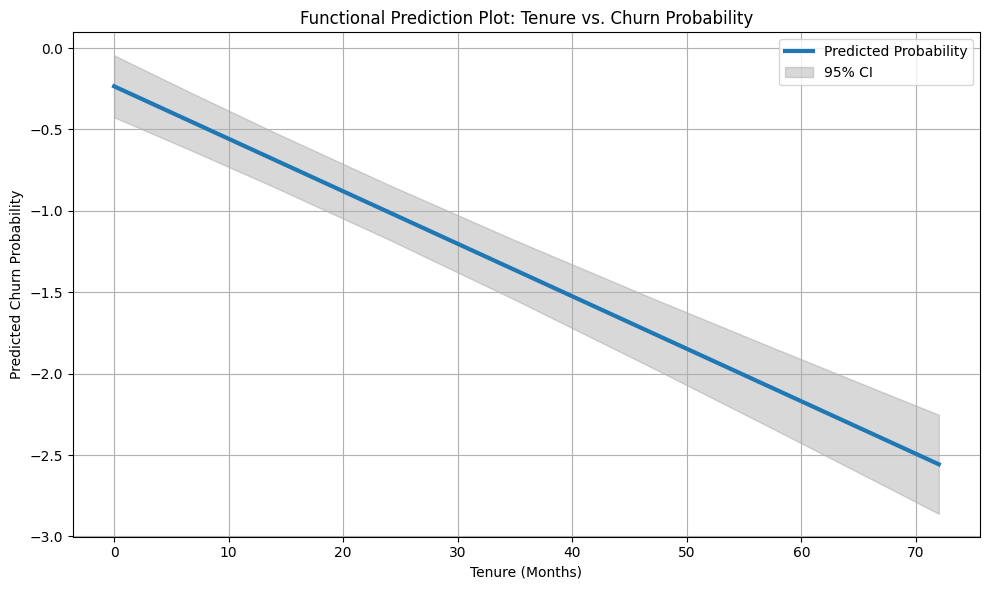

<Figure size 640x480 with 0 Axes>

In [88]:
values = {'InternetService': 'DSL',	'Contract': 'Month-to-month', 'MonthlyCharges': modelling_data['MonthlyCharges'].mean()}

# Predict functionally for tenure with confidence bands
pr, cb, fv = predict_functional(
    result, 
    "tenure", 
    values = values,
    ci_method="simultaneous"
)

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x=fv, y=pr, lw=3, label="Predicted Probability")
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.3, label="95% CI")
ax.set_xlabel("Tenure (Months)")
ax.set_ylabel("Predicted Churn Probability")
ax.set_title("Functional Prediction Plot: Tenure vs. Churn Probability")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# For slides reporting 
plt.savefig("assets/Functional Prediction Plot: Tenure vs. Churn Probability.png", bbox_inches="tight")

__Interpretation__

The model’s confidence band (95%) is relatively narrow across most of the tenure range, suggesting that the observed relationship is statistically stable and not due to sampling noise.
The functional form used here complements the model coefficient interpretation, offering a more intuitive, visual confirmation of tenure's importance.



#### __5. Deviance Residual Plot__

This helps assess how well the model fits individual observations, especially spotting where predictions deviate substantially from actual outcomes. It complements the classification metrics by giving a more nuanced view of model reliability at different probability levels.

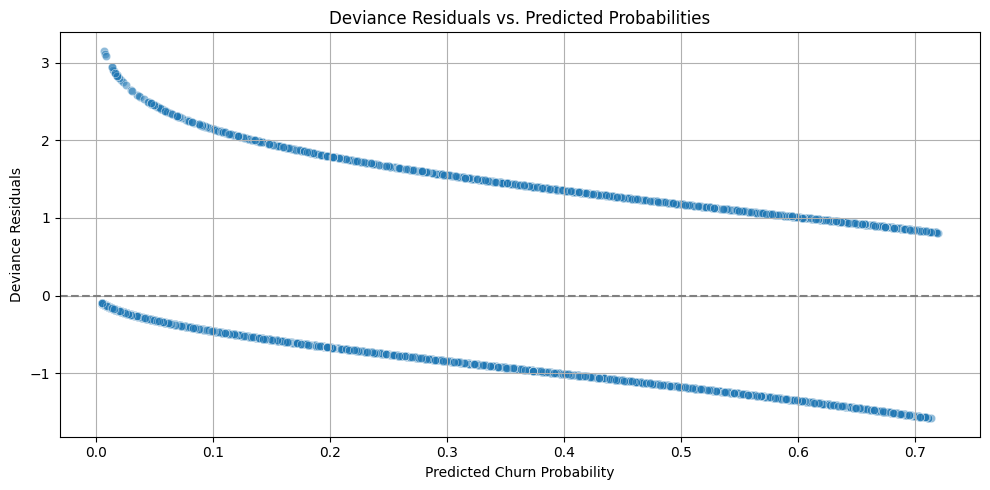

<Figure size 640x480 with 0 Axes>

In [89]:
# Calculate predicted probabilities and deviance residuals 
modelling_data["predicted_prob"] = result.predict()
modelling_data["deviance_resid"] = result.resid_deviance

# Plotting the Deviance Residuals vs. Predicted Probabilities
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=modelling_data["predicted_prob"],
    y=modelling_data["deviance_resid"],
    alpha=0.5
)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Deviance Residuals vs. Predicted Probabilities")
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Deviance Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# For slides reporting 
plt.savefig("assets/Deviance Residuals vs. Predicted Probabilities.png", bbox_inches="tight")

__Interpretation__

The deviance residuals are symmetrically distributed around zero and follow the expected pattern for a logistic model. This suggests that the model is a good fit for most observations, with no major outliers or misspecification. The absence of extreme residuals reinforces confidence in the model’s stability and the validity of its inferences.

###  __Model Finalization__

Based on the evaluation metrics — including classification report, deviance residuals, and functional prediction plots — the logistic regression model demonstrates strong discriminatory ability and interpretable coefficients that align with business expectations. 

Given its performance and interpretability, we now proceed to save the model for reuse and potential deployment in reporting or dashboard applications.


In [91]:
with open("model/glm_churn_model.pkl", "wb") as f:
    pickle.dump(result, f)

## __Conclusion__

#### __Key Findings & Business Implications__

This statistical analysis aimed to identify significant drivers of customer churn, rather than build a predictive tool. However, our inferential model reveals actionable insights with direct business implications:

1. Tenure Strongly Reduces Churn Risk
Finding: Customers with longer tenure have significantly lower churn probability.

Business Implication: Implement loyalty reward programs and milestone-based benefits to retain customers over time. Encourage long-term relationships with added incentives the longer they stay.

2. Contract Type Is a Strong Retention Lever
Finding: One-year and two-year contracts significantly reduce the odds of churn compared to month-to-month plans.

Business Implication: Promote contract-based plans over flexible month-to-month options. Consider offering discounts or bonuses for customers who switch to longer-term contracts.

3. Internet Service Type Matters
Finding: Customers using Fiber Optic services are significantly more likely to churn than those on DSL or with no internet service.

Business Implication: This suggests possible performance, cost, or satisfaction issues with the fiber optic service. Investigate further via customer surveys or support data and prioritize service quality improvements in this segment.

4. Churners Pay More Monthly
Finding: On average, churners pay significantly higher monthly charges.

Business Implication: High billing may contribute to dissatisfaction or switching behavior. Consider targeted discount offers, value-add bundles, or price rebalancing for high-paying customers at risk of churn.

5. Residual and Functional Plots Confirm Model Reliability
Functional prediction plots show churn probability steadily declines with tenure.

Deviance residuals show no major misfit patterns, indicating model reliability.

#### __Summary of Model Coefficients__

| Variable                         | Coefficient | Odds Ratio | P-value | Interpretation                                                                                                                                                                                            |
| -------------------------------- | ----------- | ---------- | ------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **tenure**                       | –0.0322     | 0.968      | <0.001  | For each additional month a customer stays, the odds of churn **decrease by \~3.2%**. This suggests customer loyalty grows over time.                                                                     |
| **MonthlyCharges**               | +0.0043     | 1.004      | 0.150   | A slight increase in churn odds with higher bills, but **not statistically significant** (p > 0.05). We include it due to its importance in business interpretation and earlier descriptive significance. |
| **Contract\_One year**           | –0.8693     | 0.42       | <0.001  | Customers on a 1-year contract are **58% less likely to churn** than those on a month-to-month contract.                                                                                                  |
| **Contract\_Two year**           | –1.7251     | 0.18       | <0.001  | Customers on a 2-year contract are **82% less likely to churn** than those on a month-to-month contract.                                                                                                  |
| **InternetService\_Fiber optic** | +1.0491     | 2.85       | <0.001  | Customers with fiber-optic internet have **2.85 times higher odds of churning** than DSL users — potentially due to cost or service dissatisfaction.                                                      |
| **InternetService\_No**          | –0.9130     | 0.40       | <0.001  | Customers without internet service are **60% less likely to churn** than DSL users — likely low-engagement customers.                                                                                     |


#### __Final Conclusion__

This analysis set out to understand the key factors influencing customer churn using logistic regression. Our findings reveal that contract type and customer tenure are the most significant predictors of churn. Customers on longer-term contracts and those with higher tenure are considerably less likely to churn, confirming the importance of customer retention strategies that emphasize long-term commitment.

Conversely, customers with fiber-optic internet — despite potentially better service — show a higher likelihood of churning, which may reflect issues related to pricing or service dissatisfaction. While monthly charges showed significance in exploratory analysis, its effect was not statistically strong in the model, suggesting that price sensitivity may interact with other variables like contract type.

Overall, the model not only provides statistical insights but also guides actionable strategies. Targeted retention efforts should prioritize month-to-month customers and recent signups, while further investigation into the fiber-optic user experience is recommended.

This project demonstrates the value of statistical modeling not just in prediction, but in surfacing meaningful patterns that can support business decisions and improve customer retention strategies.

In [ ]:
# Save model
with open("assets/glm_churn_model.pkl", "wb") as f:
    pickle.dump(churn_model, f)